In [18]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.io import imread
import torch

from nionswift_plugin.nionswift_structure_recognition.model import load_preset_model, mask_image
from nionswift_plugin.nionswift_structure_recognition.utils import walk_dir
from fourier_scale_calibration import FourierSpaceCalibrator

from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle

def plot_circles(positions, ax, colors, radius):
    patches = []
    for position, color in zip(positions, colors):
        circle = Circle((position[0],position[1]), radius, facecolor=color)
        patches.append(circle)
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
model = load_preset_model('graphene')

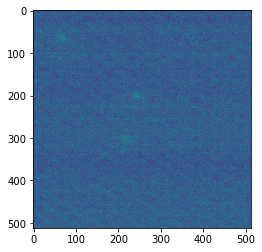

In [26]:
files = walk_dir('D:\\data\\wrong-dopants', '.tif')

image = imread(files[0])
plt.imshow(image, vmax=.0019)

## Step-wise

In [27]:
%%time
cal = FourierSpaceCalibrator(template='2nd-order-hexagonal', lattice_constant=2.45)

sampling = cal(image)

Wall time: 35.6 ms


In [28]:
sampling * 1024

84.870489570875

In [30]:
%%time
result = model(image, sampling)

Wall time: 273 ms


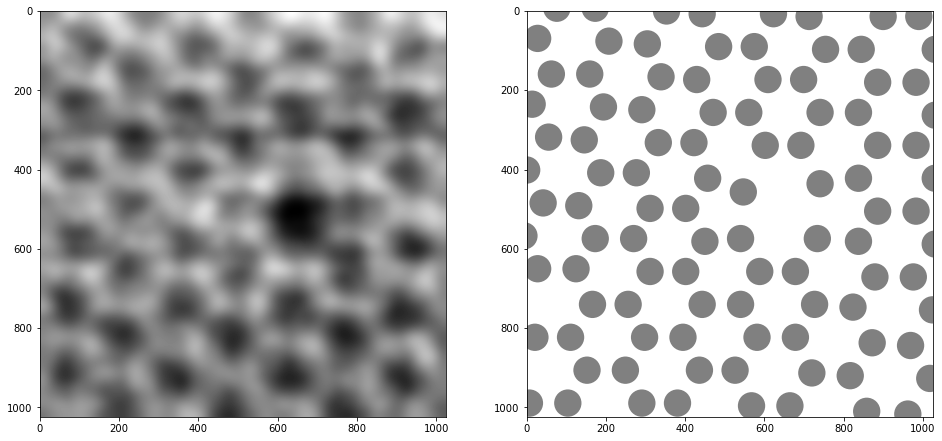

In [24]:
def plot_result(result, image, sampling):
    colors = [(.5,.5,.5) if label==0 else (1,.75,0) for label in result['labels']]

    masked_image = gaussian_filter(mask_image(image, result['contours']),.25 / sampling)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    #ax2.scatter(*result['points'].T, c=colors)
    plot_circles(result['points'], ax2, colors, .5 / sampling)

    ax2.invert_yaxis()
    ax2.set_aspect('equal', adjustable='box')
    ax2.set_xlim([0,image.shape[0]])
    ax2.set_ylim([image.shape[1],0])


    ax1.imshow(gaussian_filter(image,.25 / sampling), cmap='gray', vmax=masked_image.max())

    for contour in result['contours']:
        ax2.plot(*contour.T, color='b', label='contaminant')
        
plot_result(result, image, sampling)

## Loop all files

<ipython-input-7-db4281f59d18>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))


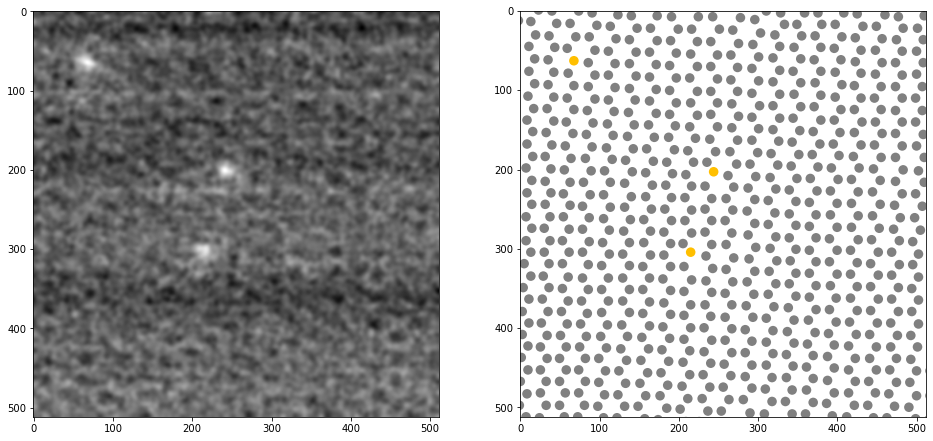

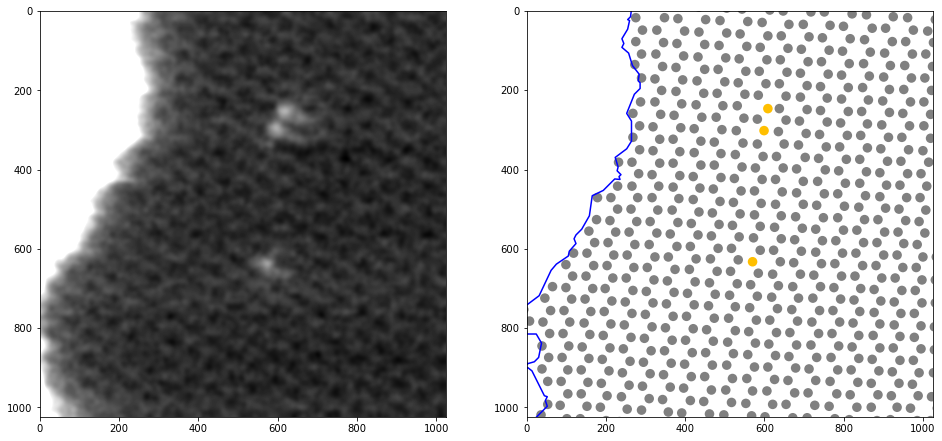

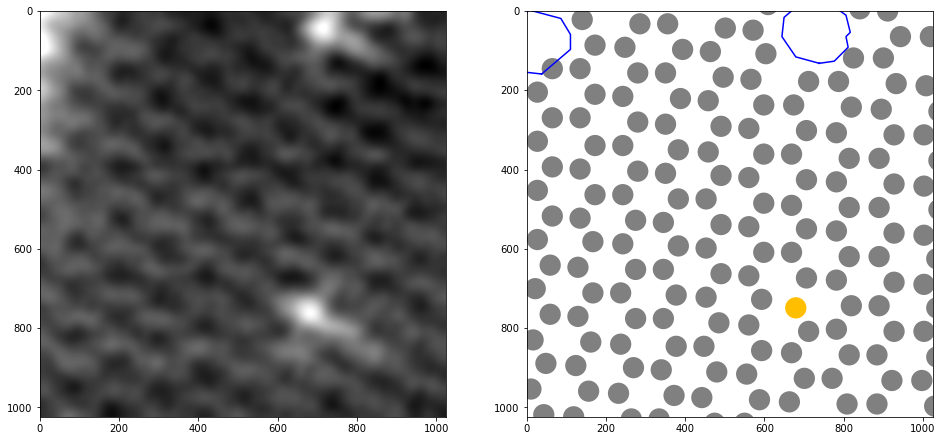

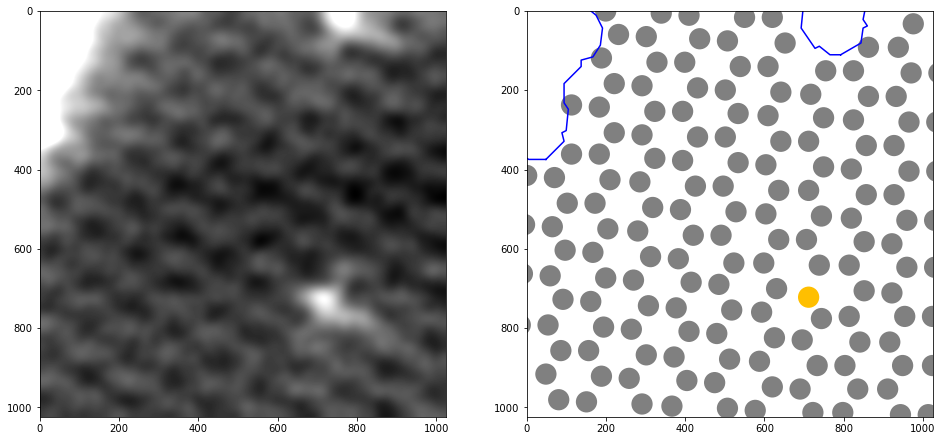

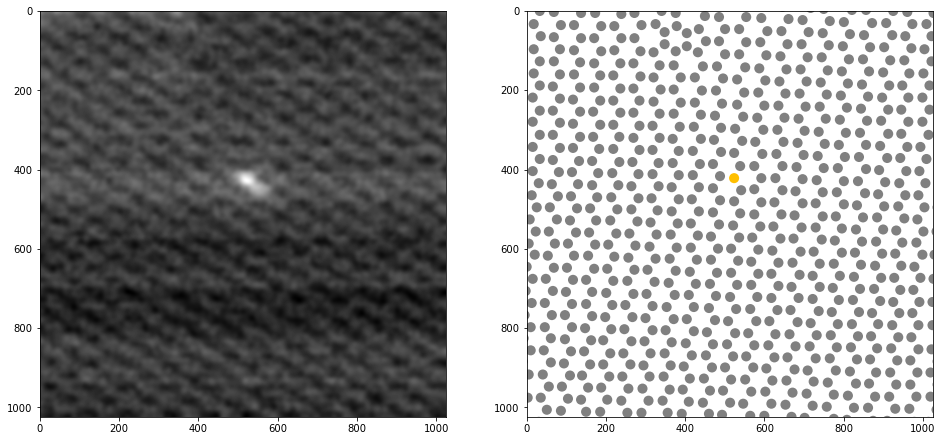

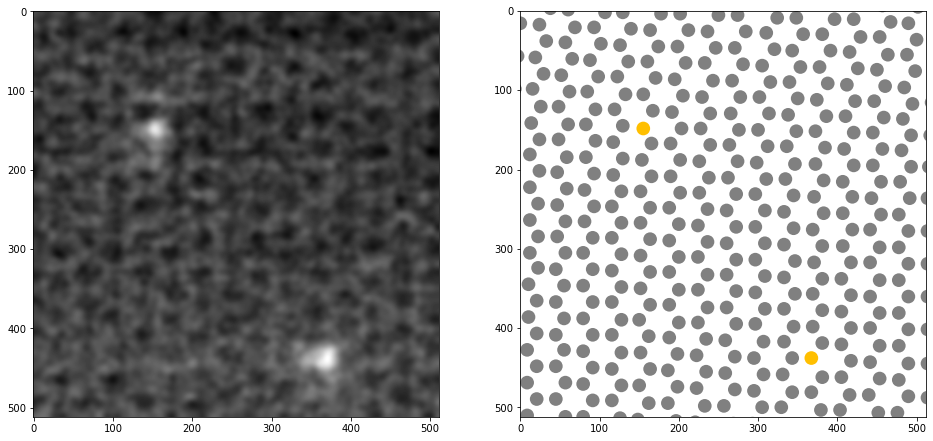

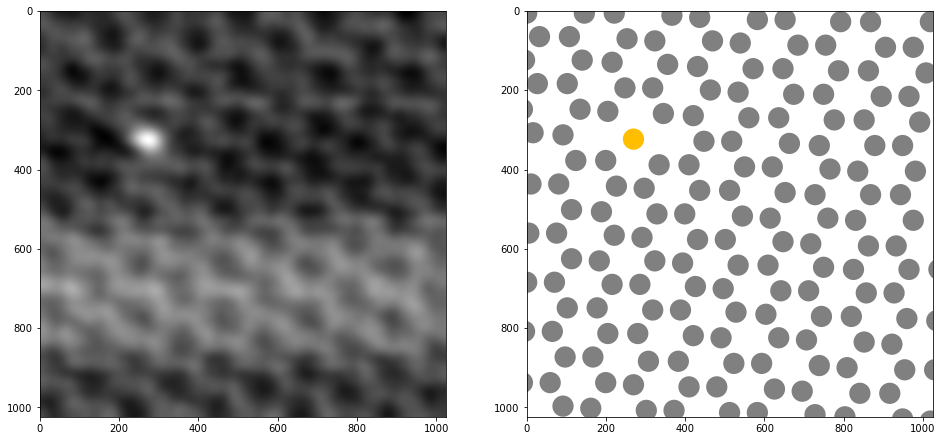

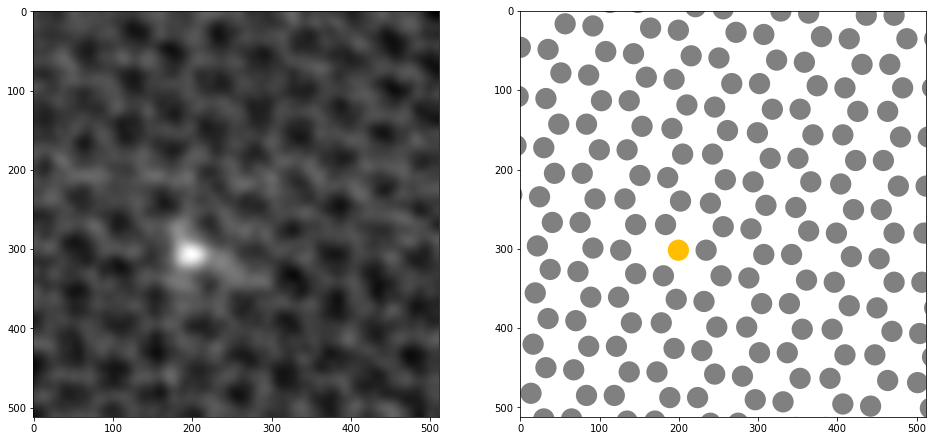

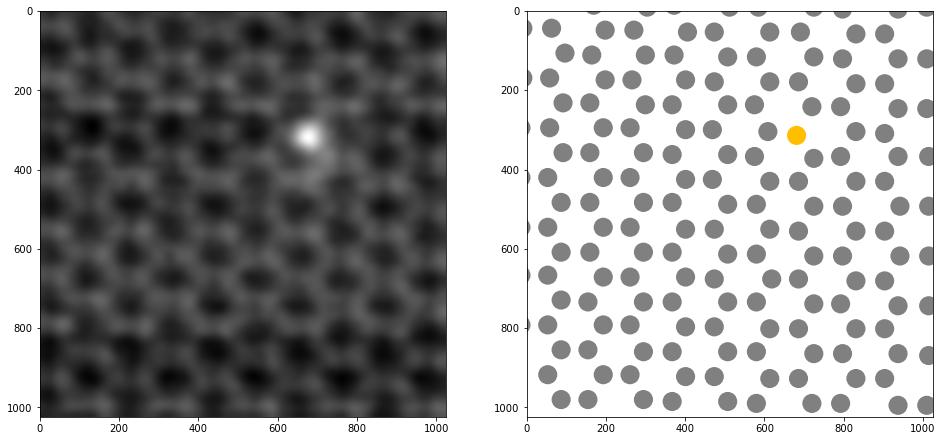

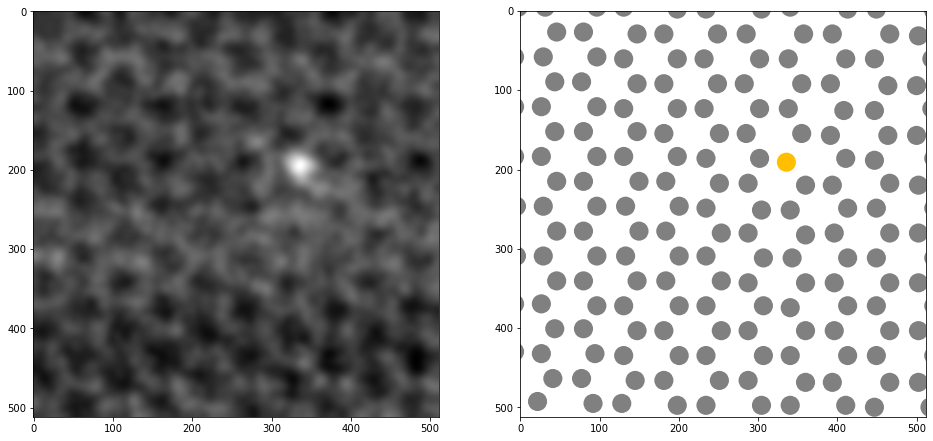

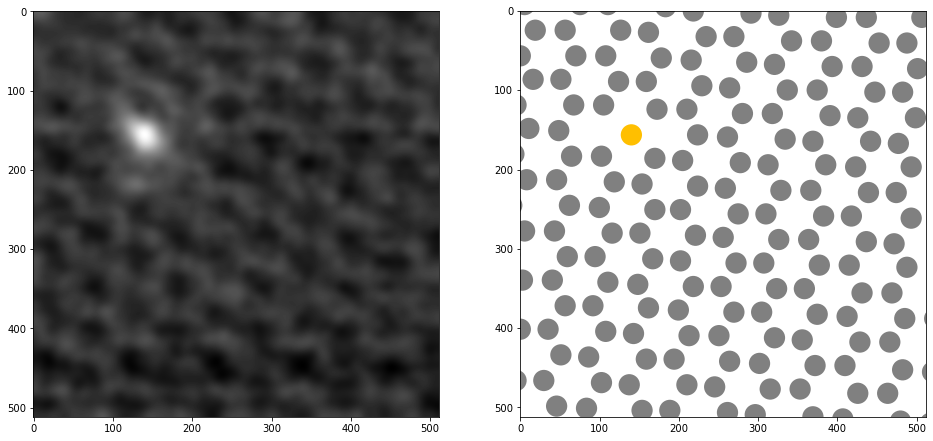

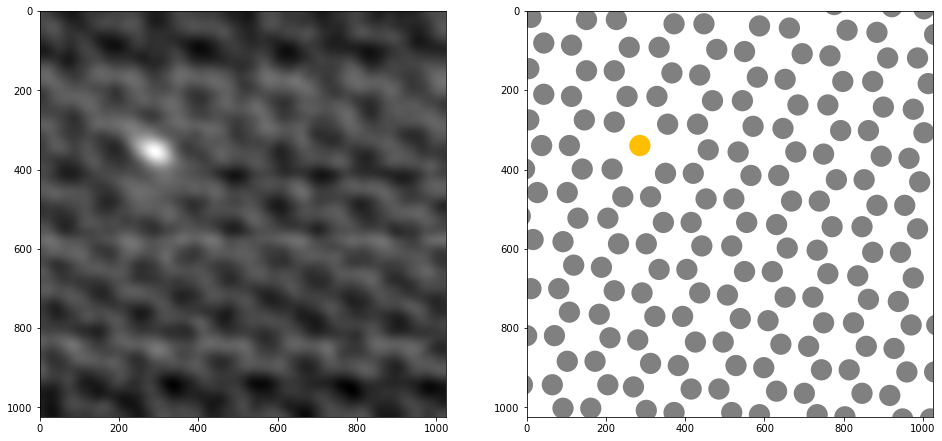

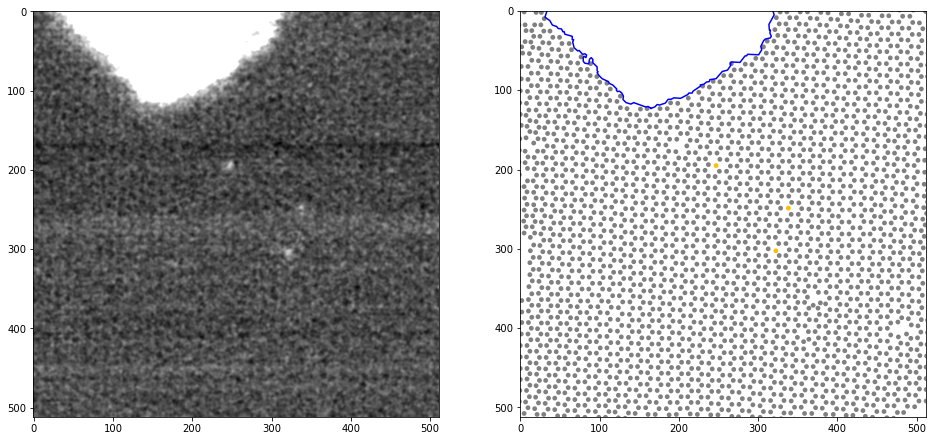

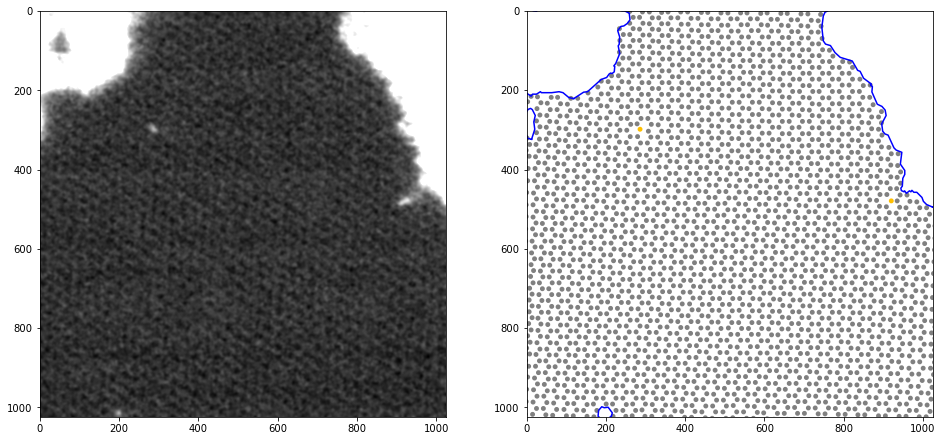

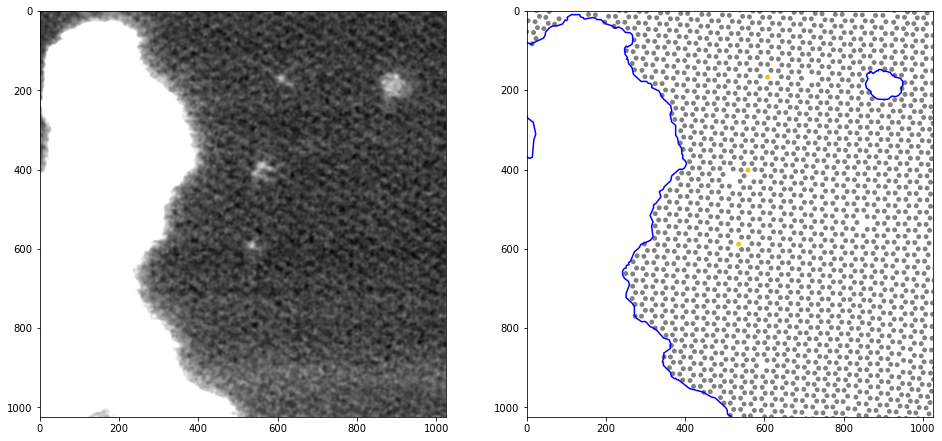

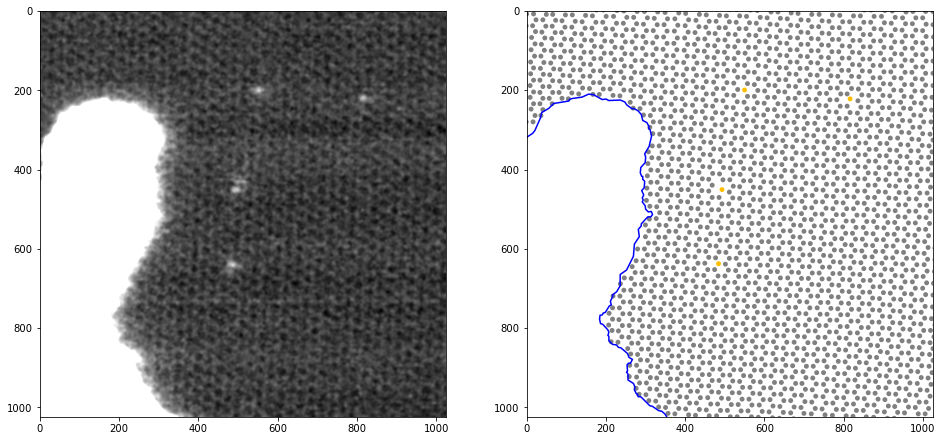

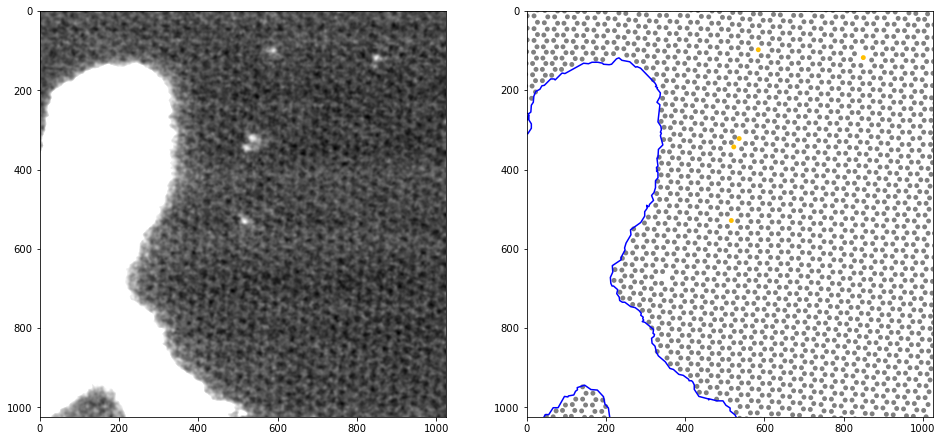

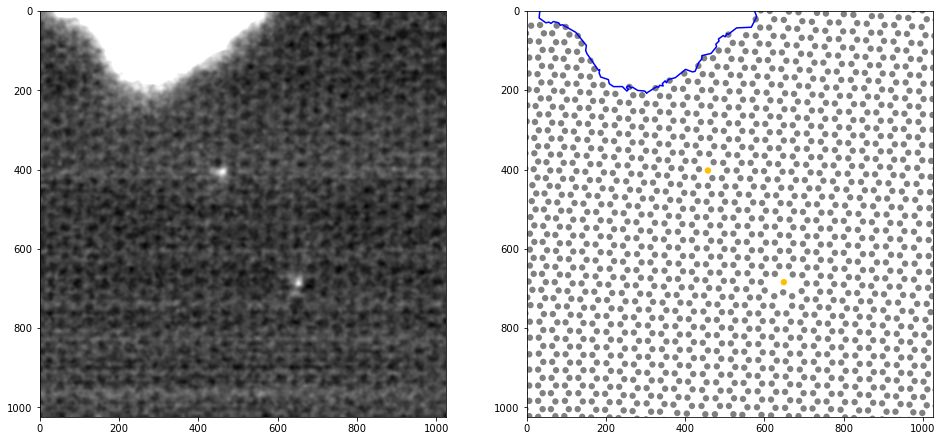

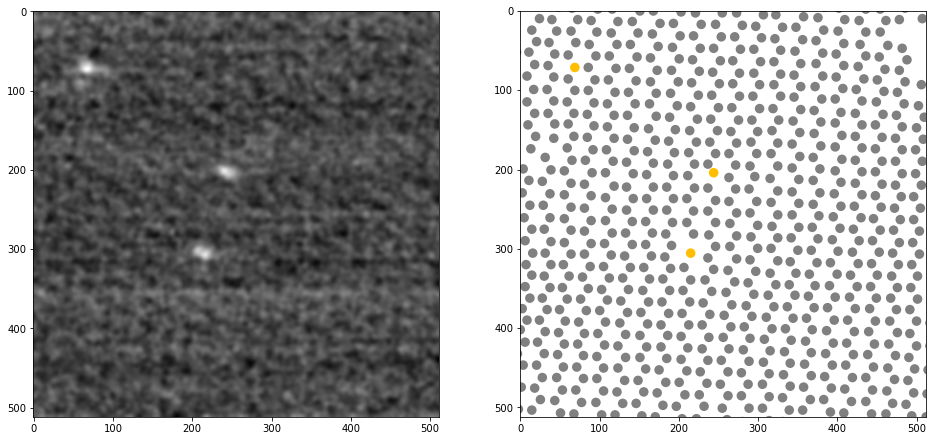

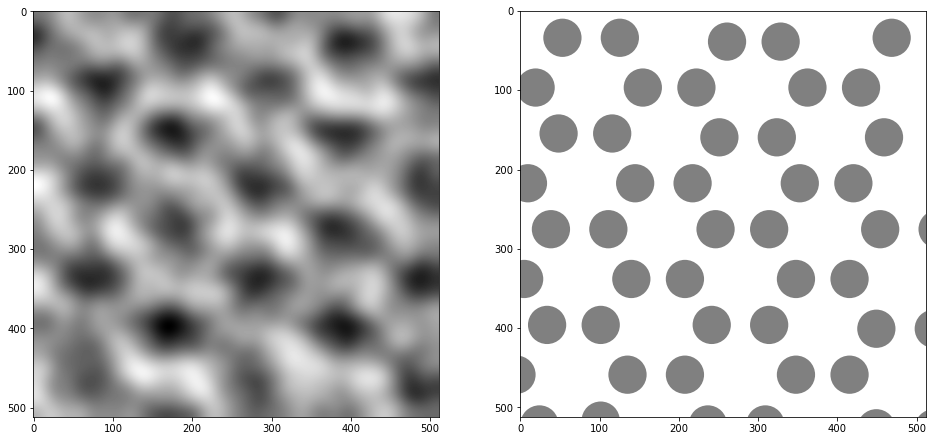

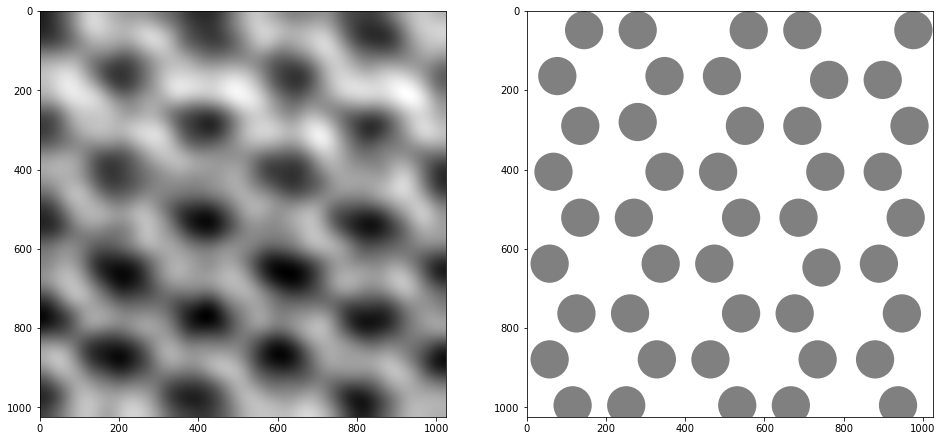

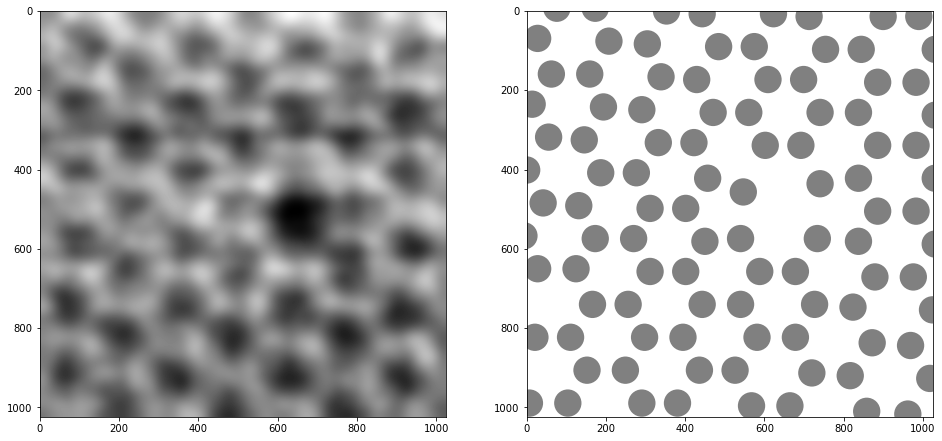

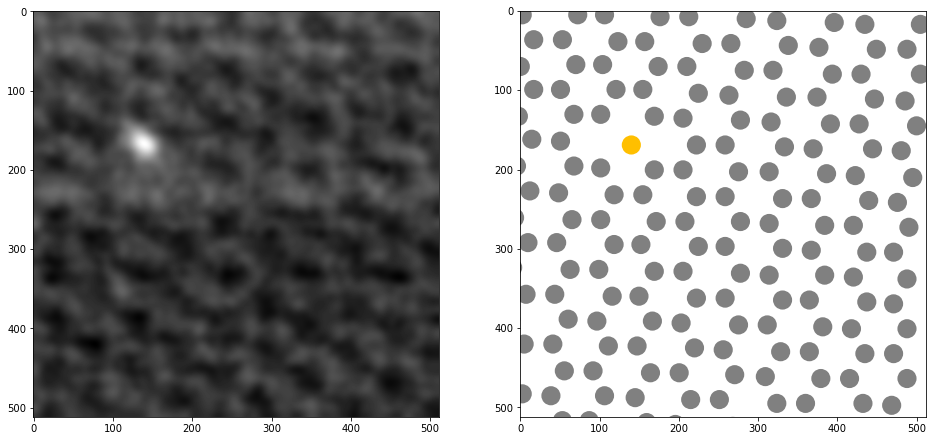

In [10]:
pdfs = []

for i, f in enumerate(files):
    image = imread(f)
    
    cal = FourierSpaceCalibrator(template='2nd-order-hexagonal', lattice_constant=2.45)

    sampling = cal(image)
    
    result = model(image, sampling)
    
    plot_result(result, image, sampling)
    
    name = f'image_{i:02d}.pdf'
    
    pdfs.append(name)
    
    plt.savefig(name)

In [12]:
from PyPDF2 import PdfFileMerger

merger = PdfFileMerger()
for pdf in pdfs:
    merger.append(pdf)

merger.write("result.pdf")
merger.close()